# Configurations

In [2]:
import os
import torch
import lightning

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from mlcolvar.cvs import VariationalAutoEncoderCV
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))


torch.manual_seed(41)

In [3]:
# Datasets

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR",
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]
n_states = len(filenames)

dataset, df = create_dataset_from_files(
	filenames,
	filter_args={'regex':'d_' }, # select distances between heavy atoms
	create_labels=True,
	return_dataframe=True,
)

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

# Load model

In [28]:

n_components = 1
encoder_layers = [45, 128, 128, n_components]
decoder_layers = [128, 128, 45]
nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = VariationalAutoEncoderCV(n_cvs = n_components, encoder_layers = encoder_layers, decoder_layers = decoder_layers, options=options )
model

VariationalAutoEncoderCV(
  (loss_fn): ELBOGaussiansLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=128, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=128, out_features=1, bias=True)
      (5): Shifted_Softplus(beta=1, threshold=20)
    )
  )
  (mean_nn): Linear(in_features=1, out_features=1, bias=True)
  (log_var_nn): Linear(in_features=1, out_features=1, bias=True)
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=128, out_features=45, bias=True)
     

In [29]:
version = "v10"
checkpoint_file = torch.load(f'./vaecv-{version}.pt')
model.load_state_dict(checkpoint_file)
model.eval()

VariationalAutoEncoderCV(
  (loss_fn): ELBOGaussiansLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=128, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=128, out_features=1, bias=True)
      (5): Shifted_Softplus(beta=1, threshold=20)
    )
  )
  (mean_nn): Linear(in_features=1, out_features=1, bias=True)
  (log_var_nn): Linear(in_features=1, out_features=1, bias=True)
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=128, out_features=45, bias=True)
     

# Visualization

In [30]:
X = dataset[:]['data']
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i]

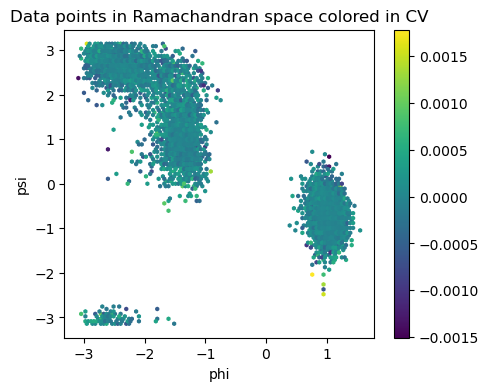

In [35]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax)
    ax.set_title(f'Data points in Ramachandran space colored in CV')

ValueError: hexbin requires x column to be numeric

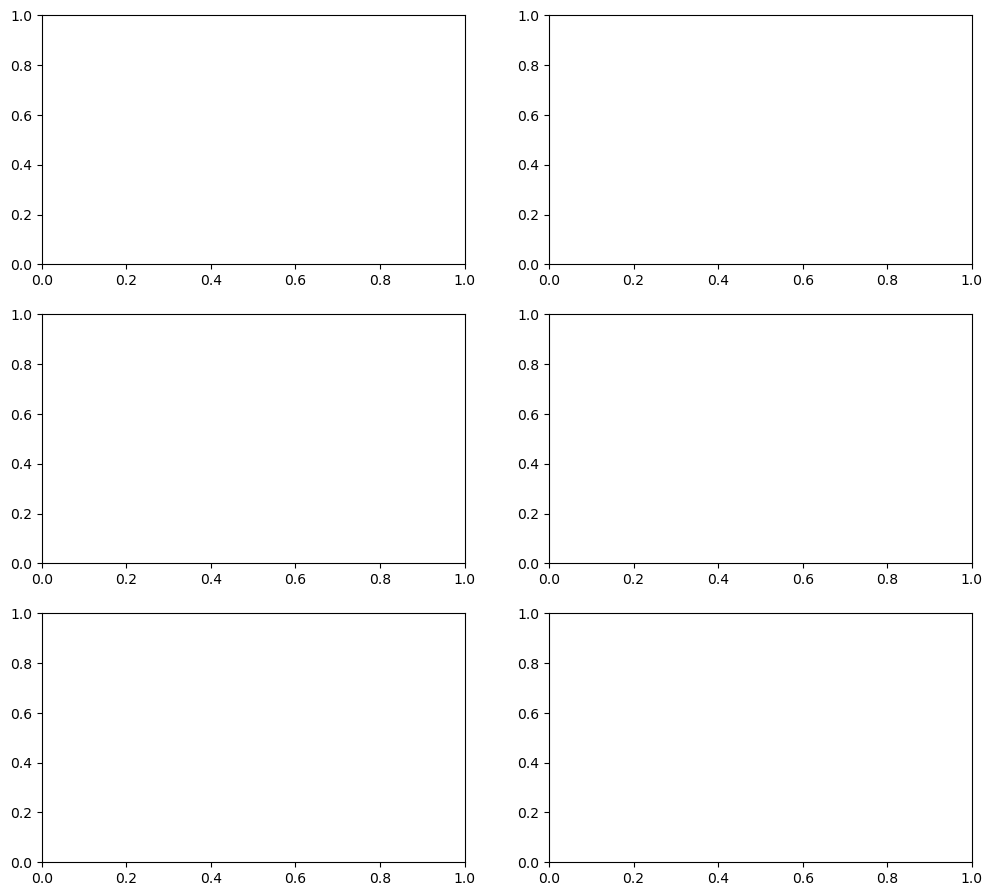

In [36]:
boundary = [-np.inf, -0.002, -0.001, 0, 0.001, 0.002, np.inf]
n_components = 1

fig,axs = plt.subplots(3, 2, figsize = ( 12, 11 ) )
axs = axs.ravel()

for i in range(0, 6):
	ax = axs[i]
	df[(df[f'CV0'] < boundary[i+1]) & (df[f'CV0'] > boundary[i])].plot.hexbin('phi', 'psi', C=f'CV0', cmap='viridis', ax=ax, vmin=-10, vmax=6)
	ax.set_title(f'CV value in [{boundary[i]},{boundary[i+1]}]')
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
plt.tight_layout()

## More data points

In [18]:
more_data = torch.load("../../../data/alanine/heavy_atom_distance.pt")
more_data.shape

torch.Size([1000000, 45])

In [19]:
with torch.no_grad():
    s = model(more_data).numpy()
    
new_df = pd.DataFrame(s, columns=[f'CV{i}' for i in range(n_components)])
new_df

,CV0
0,-0.000229
1,-0.000493
2,-0.000512
3,-0.000849
4,-0.000333
...,...
999995,0.005638
999996,0.032081
999997,0.026677
999998,0.028144


In [20]:
psis = np.load("../../../data/alanine/heavy_atom_distance_psis.npy")
phis = np.load("../../../data/alanine/heavy_atom_distance_phis.npy")
new_df['psi'] = psis
new_df['phi'] = phis
new_df

,CV0,psi,phi
0,-0.000229,2.724753,-2.496995
1,-0.000493,2.714459,-2.490017
2,-0.000512,2.701140,-2.479672
3,-0.000849,2.702199,-2.466322
4,-0.000333,2.717623,-2.420580
...,...,...,...
999995,0.005638,2.619246,-1.407471
999996,0.032081,2.730429,-1.359652
999997,0.026677,2.644886,-1.330804
999998,0.028144,2.551387,-1.297497


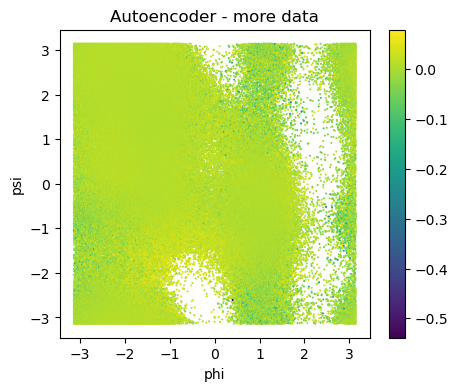

In [21]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    new_df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax, gridsize=400)
    ax.set_title(f'Autoencoder - more data')

In [1]:
boundary = [-np.inf, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, np.inf]
n_components = 1

fig,axs = plt.subplots(3, 3, figsize = ( 12, 11 ) )
axs = axs.ravel()

for i in range(0, np.min(len(boundary)-1, 9)):
	ax = axs[i]
	new_df[(new_df[f'CV0'] < boundary[i+1]) & (new_df[f'CV0'] > boundary[i])].plot.hexbin('phi', 'psi', C=f'CV0', cmap='viridis', ax=ax, vmin=-10, vmax=6)
	ax.set_title(f'CV value in [{boundary[i]},{boundary[i+1]}]')
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
plt.tight_layout()

NameError: name 'np' is not defined